In [1]:
import numpy as np
import stochpy
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

In [2]:
from matplotlib import rc
import matplotlib as mpl
import scienceplots
# Plotting style config:
plt.style.use(['science', 'nature'])

# # Optional: Set fonts for better readability
rc('font', family='serif', size=12)
rc('text', usetex=False)  # Use LaTeX if desired (change False to True if needed)

In [16]:
mu = 100
ref_price_a = ref_price_b = 100
std_price_a = std_price_b = 1

price_bins = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    300
)

# Midpoints of bins and bin width
midpoints = (price_bins[:-1] + price_bins[1:]) / 2
dp = midpoints[1] - midpoints[0]
num_bins = len(midpoints)  # Number of bins

prices_A = midpoints.copy()
prices_B = midpoints.copy()  # Same bins for B

# Parámetros de simulación
phi = 15 * dp
delta = 0.01
kappa = 0.01
beta = 0

species_A = [f"A{i+1}" for i in range(num_bins)]
species_B = [f"B{i+1}" for i in range(num_bins)]

all_species = species_A + species_B

def gaussian(x):
    return (1/(std_price_a * np.sqrt(2 * np.pi))) * np.exp(- (x - mu)**2 / (2 * std_price_a**2))

gaussian_values = [gaussian(p) for p in prices_A]

In [17]:
# Initial conditions
def get_initial_counts(n_particles):
    counts = [0] * num_bins
    for _ in range(n_particles):
        x = np.random.normal(mu, std_price_a)
        if (ref_price_b - 5 * std_price_b)  <= x <= (ref_price_a + 5 * std_price_a):
            bin_idx = int((x - (ref_price_b - 5 * std_price_b)) / dp)
            if bin_idx >= num_bins:
                bin_idx = num_bins - 1
            counts[bin_idx] += 1
    return counts

initial_A = get_initial_counts(100)
initial_B = get_initial_counts(100)

In [18]:
creation_reactions = []
for i in range(num_bins):
    # Reacciones de creación para A
    rate_A = phi * gaussian_values[i]
    rate_A_str = "{:.10f}".format(rate_A)
    creation_reactions.append(
        f"creation_{species_A[i]}:\n"
        f"    $pool > {species_A[i]}\n"
        f"    {rate_A_str}"
    )
    # Reacciones de creación para B
    rate_B = phi * gaussian_values[i]
    rate_B_str = "{:.10f}".format(rate_B)
    creation_reactions.append(
        f"creation_{species_B[i]}:\n"
        f"    $pool > {species_B[i]}\n"
        f"    {rate_B_str}"
    )

death_reactions = []
for i in range(num_bins):
    death_reactions.append(
        f"death_{species_A[i]}:\n"
        f"    {species_A[i]} > $pool\n"
        f"    delta * {species_A[i]}"
    )
    death_reactions.append(
        f"death_{species_B[i]}:\n"
        f"    {species_B[i]} > $pool\n"
        f"    delta * {species_B[i]}"
    )

interaction_reactions = []
for A_idx in range(num_bins):
    for B_idx in range(A_idx + 1, num_bins):
        A_species = species_A[A_idx]
        B_species = species_B[B_idx]
        if prices_B[B_idx] >= prices_A[A_idx]:
            price_diff = prices_B[B_idx] - prices_A[A_idx]
            rate = np.exp(beta * price_diff) * kappa
            rate_str = f"{rate:.10f}"
            reaction = (
                f"interaction_{A_species}_{B_species}:\n"
                f"    {A_species} + {B_species} > $pool\n"
                f"    {rate_str} * {A_species} * {B_species}"
            )
            interaction_reactions.append(reaction)

all_reactions = creation_reactions + death_reactions + interaction_reactions

# Escribir modelo
model_filename = "Gillespie_mercado_informal_final.psc"
full_model_path = "C:\\Stochpy\\pscmodels\\Gillespie_mercado_informal_final.psc"

with open(full_model_path, 'w') as f:
    # Condiciones iniciales
    f.write("#InitVar:\n")
    for i in range(num_bins):
        f.write(f"{species_A[i]} = {initial_A[i]}\n")
    for i in range(num_bins):
        f.write(f"{species_B[i]} = {initial_B[i]}\n")
    f.write("\n")
    
    # Parámetros
    f.write("#InitPar:\n")
    f.write(f"delta = {delta}\n")
    f.write("\n")
    
    # Reacciones
    f.write("#Reactions:\n")
    for reaction in all_reactions:
        f.write(reaction + "\n\n")

model = stochpy.SSA()
model.Model(full_model_path)

In [19]:
desired_order =  species_A + species_B
num_sims = 5
model.Endtime(1000)
# Run the simulation with the specified order
model.DoStochSim(
    # IsOnlyLastTimepoint=True,
    trajectories = num_sims,
    species_selection=desired_order  # Forces the order
)

In [20]:
total_a_sim_array = []
total_b_sim_array = []
stationary_a_sim_array = []
stationary_b_sim_array = []

for i in range(num_sims):

    model.GetTrajectoryData(i+1)

    total_timepoints = len(model.data_stochsim.time)

    # Calcular distribución final promediada (últimos x% de pasos)
    percent = 0.5
    last_percent = int(percent * total_timepoints)
    start_idx = max(0, total_timepoints - last_percent)
    # start_idx = -1

    counts_A = model.data_stochsim.species[:,:num_bins]
    counts_B = model.data_stochsim.species[:,num_bins:]

    final_A_counts = np.mean(counts_A[start_idx:, :], axis=0) / dp
    final_B_counts = np.mean(counts_B[start_idx:, :], axis=0) / dp

    total_particles_A = []
    total_particles_B = [] 

    times = model.data_stochsim.time

    for t in range(total_timepoints):

        counts_Ai = counts_A[t]
        counts_Bi = counts_B[t]

        total_particles_A.append(np.sum(counts_Ai)) 
        total_particles_B.append(np.sum(counts_Bi))

    total_particles_A = np.column_stack((total_particles_A,times))
    total_particles_B = np.column_stack((total_particles_B,times))
        
    total_a_sim_array.append(total_particles_A)
    total_b_sim_array.append(total_particles_B)
    stationary_a_sim_array.append(final_A_counts)
    stationary_b_sim_array.append(final_B_counts)


dt = 1  # e.g., every 0.01 time units
common_time = np.arange(0, 1000 + dt, dt)

def interpolate_series(times, values, common_time):
    # Handle possible duplicate times (e.g., in stochastic simulations)
    # Remove duplicates by keeping the first occurrence
    times, idx = np.unique(times, return_index=True)
    values = values[idx]

    # Create interpolation function
    interp_func = interp1d(times, values, kind='linear', fill_value='extrapolate')
    
    # Interpolate onto common time grid
    return interp_func(common_time)

all_interpolated_a = []  # List to store interpolated time series

for sim_data in total_a_sim_array:
    times = sim_data[:,1]
    values = sim_data[:,0]
    interpolated = interpolate_series(times, values, common_time)
    all_interpolated_a.append(interpolated)

all_interpolated_a = np.array(all_interpolated_a)
total_a_sim_array = np.mean(all_interpolated_a, axis=0)

all_interpolated_b = []  # List to store interpolated time series

for sim_data in total_b_sim_array:
    times = sim_data[:,1]
    values = sim_data[:,0]
    interpolated = interpolate_series(times, values, common_time)
    all_interpolated_b.append(interpolated)

all_interpolated_b = np.array(all_interpolated_b)
total_b_sim_array = np.mean(all_interpolated_b, axis=0)

mean_stationary_a_sim_array = np.mean(np.array(stationary_a_sim_array), axis = 0)
mean_stationary_b_sim_array = np.mean(np.array(stationary_b_sim_array), axis = 0)

std_total_a_sim_array = np.std(all_interpolated_a, axis=0) / np.sqrt(num_sims)
upper_bound_total_a_sim_array = total_a_sim_array + std_total_a_sim_array
lower_bound_total_a_sim_array = total_a_sim_array - std_total_a_sim_array

std_total_b_sim_array = np.std(all_interpolated_b, axis=0) / np.sqrt(num_sims)
upper_bound_total_b_sim_array = total_b_sim_array + std_total_b_sim_array
lower_bound_total_b_sim_array = total_b_sim_array - std_total_b_sim_array

std_stationary_a_sim_array = np.std(stationary_a_sim_array, axis=0) / np.sqrt(num_sims)
upper_mean_stationary_a_sim_array = mean_stationary_a_sim_array + std_stationary_a_sim_array
lower_mean_stationary_a_sim_array = mean_stationary_a_sim_array - std_stationary_a_sim_array

std_stationary_b_sim_array = np.std(stationary_b_sim_array, axis=0) / np.sqrt(num_sims)
upper_mean_stationary_b_sim_array = mean_stationary_b_sim_array + std_stationary_b_sim_array
lower_mean_stationary_b_sim_array = mean_stationary_b_sim_array - std_stationary_b_sim_array

with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_A_totales_gillespie.pkl", 'wb') as f:
    pickle.dump(total_a_sim_array,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_B_totales_gillespie.pkl", 'wb') as f:
    pickle.dump(total_b_sim_array,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\times_gillespie.pkl", 'wb') as f:
    pickle.dump(common_time,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_A_estacionario_gillespie.pkl", 'wb') as f:
    pickle.dump(mean_stationary_a_sim_array,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_B_estacionario_gillespie.pkl", 'wb') as f:
    pickle.dump(mean_stationary_b_sim_array,f)

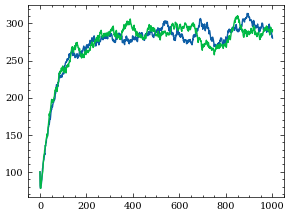

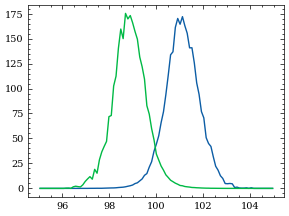

In [12]:
plt.plot(common_time, total_a_sim_array)
plt.plot(common_time, total_b_sim_array)
plt.show()

plt.plot(midpoints, mean_stationary_a_sim_array)
plt.plot(midpoints, mean_stationary_b_sim_array)
plt.show()

In [92]:
# # Mostrar número de timepoints
# total_timepoints = len(model.data_stochsim.time)

# # Calcular distribución final promediada (últimos x% de pasos)
# percent = 0.5
# last_percent = int(percent * total_timepoints)
# start_idx = max(0, total_timepoints - last_percent)
# # start_idx = -1

# counts_A = model.data_stochsim.species[:,:num_bins]
# counts_B = model.data_stochsim.species[:,num_bins:]

# final_A_counts = np.mean(counts_A[start_idx:, :], axis=0) / dp
# final_B_counts = np.mean(counts_B[start_idx:, :], axis=0) / dp

# bar_width = dp * 0.15

# # Calcular desviación estándar de las distribuciones de precios
# times = model.data_stochsim.time
# std_A_over_time = []
# std_B_over_time = []
# total_particles_A = []
# total_particles_B = [] 
# mean_price_A_over_time = []
# mean_price_B_over_time = []

# for t in range(total_timepoints):

#     counts_Ai = counts_A[t]
#     counts_Bi = counts_B[t]

#     total_particles_A.append(np.sum(counts_Ai)) 
#     total_particles_B.append(np.sum(counts_Bi))
    
#     total_A = np.sum(counts_Ai)
#     if total_A > 0:
#         mean_A = np.dot(prices_A, counts_Ai) / total_A
#         variance_A = np.dot((prices_A - mean_A)**2, counts_Ai) / total_A
#         std_A = np.sqrt(variance_A)
#     else:
#         std_A = 0
    
#     total_B = np.sum(counts_Bi)
#     if total_B > 0:
#         mean_B = np.dot(prices_B, counts_Bi) / total_B
#         variance_B = np.dot((prices_B - mean_B)**2, counts_Bi) / total_B
#         std_B = np.sqrt(variance_B)
#     else:
#         std_B = 0
    
#     std_A_over_time.append(std_A)
#     std_B_over_time.append(std_B)
#     mean_price_A_over_time.append(mean_A)
#     mean_price_B_over_time.append(mean_B)

# # Distribución final promediada
# plt.figure(figsize=(10, 6))
# plt.bar(prices_A, final_A_counts, bar_width, align="center", alpha=0.8, label='A (Final)', linewidth = 2)
# plt.bar([p + dp*0.5 for p in prices_A], final_B_counts, bar_width, align="center", alpha=0.8, label='B (Final)', linewidth = 2)
# # plt.plot(prices_A, int(phi) * np.array(gaussian_values) / delta)
# plt.title(f'Distribución Final Promediada (Últimos {percent*100}% de Pasos)')
# plt.xlabel('Precio')
# plt.ylabel('Cantidad Promedio')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot de los totales de particulas
# plt.figure(figsize=(10, 6))
# plt.plot(times, total_particles_A, label='A')
# plt.plot(times, total_particles_B, label='B')
# plt.title('Cantidad total de particulas por tipo a lo largo del Tiempo')
# plt.xlabel('Tiempo')
# plt.ylabel('Cantidad')
# plt.legend()
# plt.grid(True)
# plt.show()

In [13]:
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_A.pkl", 'wb') as f:
    pickle.dump(total_particles_A,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_B.pkl", 'wb') as f:
    pickle.dump(total_particles_B,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\times.pkl", 'wb') as f:
    pickle.dump(times,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_A_estacionario.pkl", 'wb') as f:
    pickle.dump(final_A_counts,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\n_B_estacionario.pkl", 'wb') as f:
    pickle.dump(final_B_counts,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\initial_A.pkl", 'wb') as f:
    pickle.dump(initial_A,f)
with open("C:\\Users\\A\\Documents\\Investigacion\\Tesis\\ipython_notebooks\\Codigos finales para la tesis\\resources\\Gillespie mercado informal\\initial_B.pkl", 'wb') as f:
    pickle.dump(initial_B,f)